# Topic modeling

In this lab, we will be looking at Topic Modeling using LDA and LSA on 20 News groups dataset from sklearn.

### Brief recap on Topic Modeling

Topic modeling is an unsupervised machine learning technique used to identify hidden topics in a collection of documents. It groups words in the text into clusters or "topics" based on their statistical co-occurrence, allowing us to understand the structure and themes of the text corpus without needing labeled data. It is commonly used in areas like document clustering, text classification, and summarization.

Key applications of topic modeling include:

- Understanding large text datasets (e.g., customer reviews, news articles).
- Organizing and classifying content.
- Improving information retrieval systems.


### Latent Semantic Analysis (LSA)

LSA, or Latent Semantic Analysis, is a foundational technique for topic modeling. It uses singular value decomposition (SVD) to reduce the dimensionality of a term-document matrix created using text data. By projecting data into a lower-dimensional space, LSA identifies latent patterns and clusters words into topics.

How it works:

- Text is represented as a term-document matrix (e.g., TF-IDF matrix).
- SVD decomposes the matrix into three components:
    - U: Matrix representing documents and their relationship to latent topics.
    - Σ: Diagonal matrix of singular values representing the importance of each topic.
    - Vᵀ: Matrix representing words and their relationship to latent topics.
- Topics are derived from the lower-dimensional representation of terms and documents.

**Example of Latent Semantic Analysis (LSA)**
Suppose you're analyzing news articles and want to find the underlying topics. LSA identifies latent topics like:

- Articles mentioning sports might frequently use words like "team," "score," "goal."
- Articles discussing politics might include terms like "election," "policy," "government."

By reducing the dimensionality of the term-document matrix, LSA clusters these terms into topics, allowing you to group and understand your dataset quickly.

### Latent Dirichlet Allocation (LDA)

LDA, or Latent Dirichlet Allocation, is a generative probabilistic model for topic modeling. Unlike LSA, LDA models the document generation process, assuming that each document is a mixture of multiple topics and each word is drawn from one of these topics.

How it works:

- Documents are modeled as a mixture of topics.
- Each topic is modeled as a distribution over words.
- The algorithm infers the topic-word and document-topic distributions using statistical techniques like Gibbs sampling or Variational Bayes.

**Example of Latent Dirichlet Allocation (LDA)**

Imagine you have a dataset of movie plot summaries. Using LDA, you could identify topics such as:

- Topic 1 (Romance): Words like "love," "relationship," "marriage."
- Topic 2 (Action): Words like "fight," "explosion," "hero."
- Topic 3 (Sci-Fi): Words like "alien," "space," "future."
LDA provides probabilistic distributions, showing which topics are prominent in each movie, enabling tasks like genre classification or content recommendations.


## Import libraries

In [11]:
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
# from jupytertehmes import jtplot

import umap
from sklearn.decomposition import TruncatedSVD, PCA, NMF, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim import corpora
from gensim.models.ldamodel import LdaModel

In [12]:
# set plot rc parameters

# jtplot.style(grid=False)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#464646'
#plt.rcParams['axes.edgecolor'] = '#FFFFFF'
plt.rcParams['figure.figsize'] = 10, 7
plt.rcParams['text.color'] = '#666666'
plt.rcParams['axes.labelcolor'] = '#666666'
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.color'] = '#666666'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.color'] = '#666666'
plt.rcParams['ytick.labelsize'] = 14

# plt.rcParams['font.size'] = 16

sns.color_palette('dark')
%matplotlib inline

## Load data

In [13]:
# Load news data set
# remove meta data headers footers and quotes from news dataset
dataset = fetch_20newsgroups(shuffle=True,
                            random_state=32,
                            remove=('headers', 'footers', 'qutes'))

In [14]:
# sneak peek of the news articles
for idx in range(10):
    print(dataset.data[idx],'\n\n','#'*100, '\n\n')

The real question here in my opinion is what Motorola processors running system
7 on a MAC are comparable to what Intel processors running Windows on a PC?  I
recall there being a conversation here that a 486/25 running Windows benchmarks
at about the same speed as 25Mhz 030 in system 7.  I don't know if that is
true, but I would love to hear if anyone has any technical data on this.

-David 

 #################################################################################################### 


Please could someone in the US give me the current street 
prices on the following, with and without any relevant taxes:

 8 Mb 72 pin SIMM
16 Mb 72 pin SIMM (both for Mac LC III)

Are any tax refunds possible if they are to be exported
to the UK? Can you recommend a reliable supplier? 

 #################################################################################################### 


Can somebody please help me with information about an
American Magnetics Corporation Magstripe Card Read

In [15]:
# put your data into a dataframe
news_df = pd.DataFrame({'News': dataset.data,
                       'Target': dataset.target})

# get dimensions of data 
news_df.shape

(11314, 2)

In [16]:
news_df.head()

,News,Target
0,The real question here in my opinion is what M...,4
1,Please could someone in the US give me the cur...,4
2,Can somebody please help me with information a...,12
3,In article <2077@rwing.UUCP> pat@rwing.UUCP (P...,16
4,"From article <1pq6i2$a1f@news.ysu.edu>, by ak2...",7


In [17]:
# replace target names from target numbers in our news data frame
news_df['Target_name'] = news_df['Target'].apply(lambda x: dataset.target_names[x])

In [18]:
news_df.head()

,News,Target,Target_name
0,The real question here in my opinion is what M...,4,comp.sys.mac.hardware
1,Please could someone in the US give me the cur...,4,comp.sys.mac.hardware
2,Can somebody please help me with information a...,12,sci.electronics
3,In article <2077@rwing.UUCP> pat@rwing.UUCP (P...,16,talk.politics.guns
4,"From article <1pq6i2$a1f@news.ysu.edu>, by ak2...",7,rec.autos


### Distribution of Topics

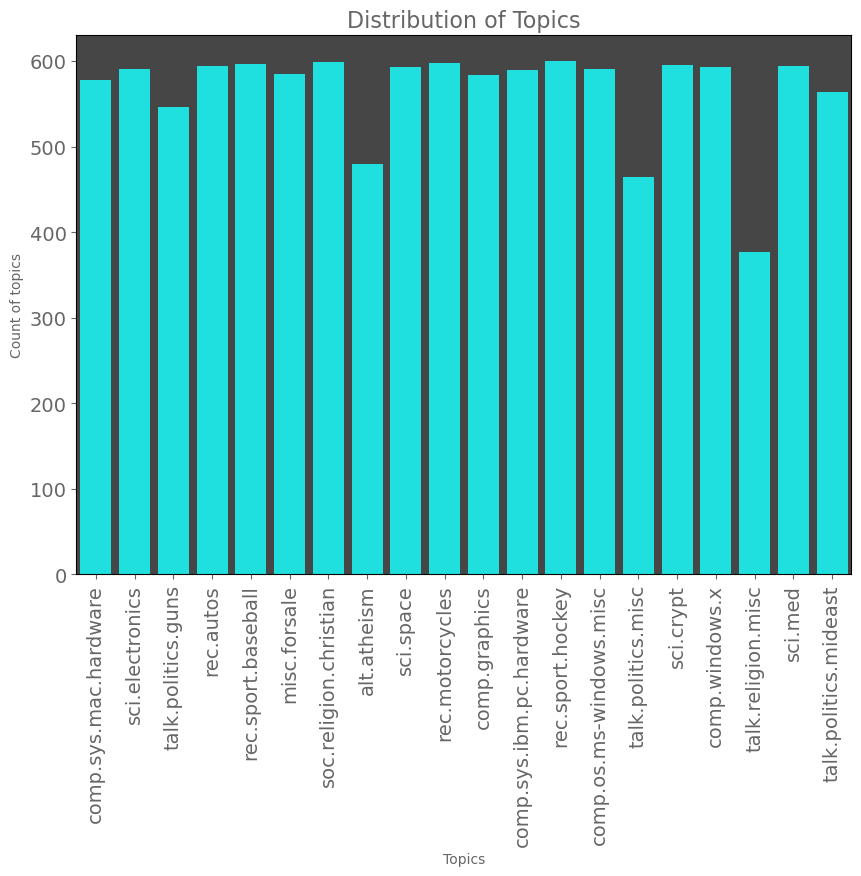

In [19]:
# Plot distribution of topics
fig = plt.figure(figsize=[10, 7])
sns.countplot(data=news_df, x='Target_name', color='cyan')
plt.title('Distribution of Topics')
plt.xlabel('Topics')
plt.ylabel('Count of topics')
plt.xticks(rotation=90)
plt.show()

*  All the articles are almost uniformly ditributed among 20 topics

## Text preprocessing


Here we preprocess text by converting it to lowercase, removing non-alphabetic characters, and filtering out stopwords and short words (length < 3). It then tokenizes the text, lemmatizes each word to its base form, and reconstructs the cleaned text into a sentence. Finally, the progress_apply method is used with tqdm to apply this cleaning function to each row of the News column in news_df, providing a progress bar for the process.

In [20]:
# clean text data
# remove non alphabetic characters
# remove stopwords and lemmatize

def clean_text(sentence):
    # remove non alphabetic sequences
    pattern = re.compile(r'[^a-z]+')
    sentence = sentence.lower()
    sentence = pattern.sub(' ', sentence).strip()
    
    # Tokenize
    word_list = word_tokenize(sentence)
    
    # stop words
    stopwords_list = set(stopwords.words('english'))
    
    # remove stop words
    word_list = [word for word in word_list if word not in stopwords_list]
    # remove very small words, length < 3
    # they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 2]
  
    # lemmatize
    lemma = WordNetLemmatizer()
    word_list = [lemma.lemmatize(word) for word in word_list]
    # list to sentence
    sentence = ' '.join(word_list)
    
    return sentence

# we'll use tqdm to monitor progress of data cleaning process
# create tqdm for pandas
tqdm.pandas()
# clean text data
news_df['News'] = news_df['News'].progress_apply(lambda x: clean_text(str(x)))

100%|██████████| 11314/11314 [00:08<00:00, 1377.89it/s]


In [21]:
news_df.head()

,News,Target,Target_name
0,real question opinion motorola processor runni...,4,comp.sys.mac.hardware
1,please could someone give current street price...,4,comp.sys.mac.hardware
2,somebody please help information american magn...,12,sci.electronics
3,article rwing uucp pat rwing uucp pat myrto wr...,16,talk.politics.guns
4,article news ysu edu yfn ysu edu john daker cu...,7,rec.autos


### WordCloud of processed text

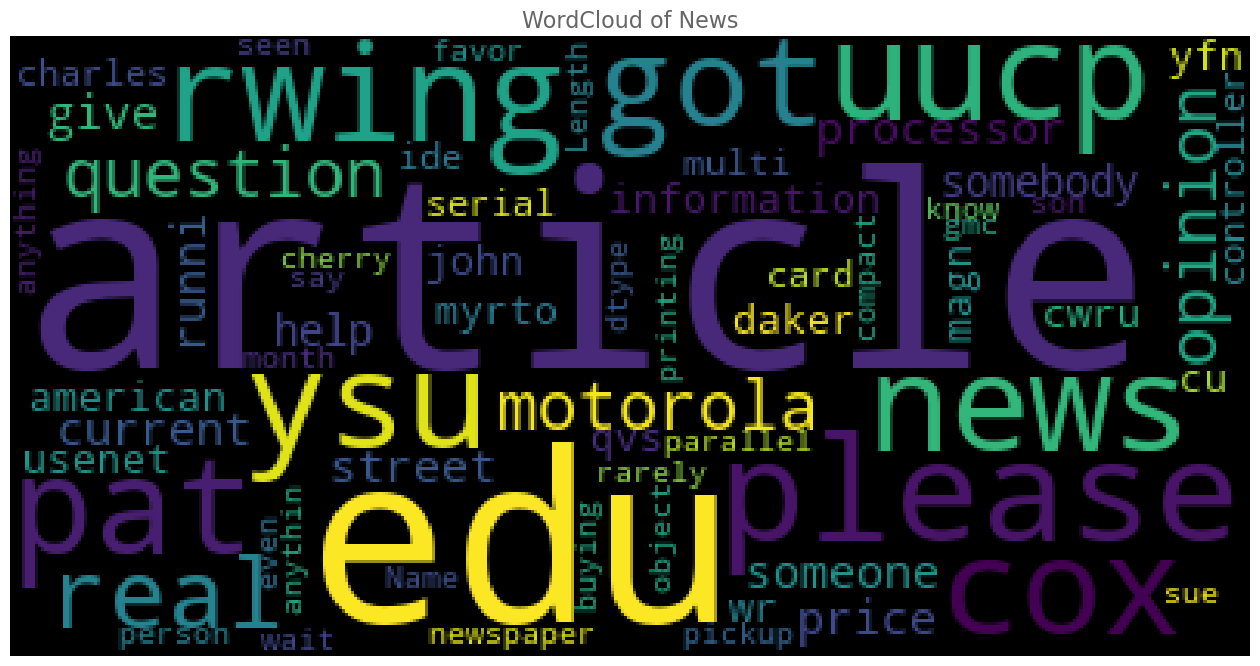

In [22]:
# plot word count for news text
wordcloud = WordCloud(background_color='black',
                      max_words=200).generate(str(news_df['News']))
fig = plt.figure(figsize=[16,16])
plt.title('WordCloud of News')
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

### Featurize News article

*  For this, we'll use TF-IDF vectorizer
*  It evaluates how important a word is in a document relative to a collection (or corpus) of documents. The importance increases proportionally with the number of times a word appears in a document but decreases with its frequency across the entire corpus.

In [23]:
# vectorize text data
tfid_vec = TfidfVectorizer(tokenizer=lambda x: str(x).split())
X = tfid_vec.fit_transform(news_df['News'])
X.shape

/Users/divyahegde/anaconda3/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(11314, 73392)

### Visualize news vectors

#### t-SNE

Here we visualize high-dimensional text data using **t-SNE**, a dimensionality reduction technique, and colors the points based on their assigned topics. It first converts the sparse matrix `X` (e.g., from TF-IDF) into a dense format, then applies t-SNE to project the data into a 2D space. Each point is plotted in a scatter plot with colors determined by the `Target_name` column, which is factorized into numerical values, and a colorbar indicates the mapping of colors to topics for interpretability.

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 11314 samples in 1.668s...
[t-SNE] Computed neighbors for 11314 samples in 93.023s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11314
[t-SNE] Computed conditional probabilities for sample 2000 / 11314
[t-SNE] Computed conditional probabilities for sample 3000 / 11314
[t-SNE] Computed conditional probabilities for sample 4000 / 11314
[t-SNE] Computed conditional probabilities for sample 5000 / 11314
[t-SNE] Computed conditional probabilities for sample 6000 / 11314
[t-SNE] Computed conditional probabilities for sample 7000 / 11314
[t-SNE] Computed conditional probabilities for sample 8000 / 11314
[t-SNE] Computed conditional probabilities for sample 9000 / 11314
[t-SNE] Computed conditional probabilities for sample 10000 / 11314
[t-SNE] Computed conditional probabilities for sample 11000 / 11314
[t-SNE] Computed conditional probabilities for sample 11314 / 11314
[t-SNE] Mean sigma: 0.497289
[t-SNE] KL divergen

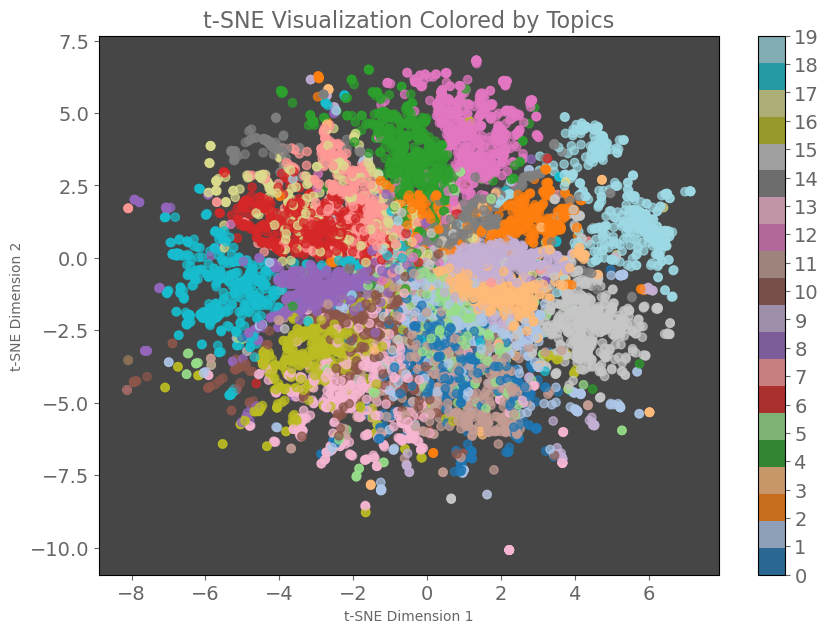

In [28]:
# Convert sparse matrix to dense
X_dense = X.toarray()

# Fit t-SNE
tsne = TSNE(
    n_components=2,
    perplexity=50,
    learning_rate=300,
    n_iter=800,
    verbose=1,
    init='random'
)
components = tsne.fit_transform(X_dense)

# Ensure you have a categorical variable for coloring (e.g., topics)
labels = news_df['Target_name']  # Replace with the column representing topics

# Plot with color mapping
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    components[:, 0],
    components[:, 1],
    c=labels.factorize()[0],  # Factorize converts categories to numbers
    cmap='tab20',  # Colormap with multiple distinct colors
    alpha=0.7
)
plt.colorbar(scatter, ticks=range(len(labels.unique())))
plt.title("t-SNE Visualization Colored by Topics")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

### Latent Semantic Analysis (LSA)

Performing SVD to reduce dimensionality of input to 3 dimensions.

In [29]:
# create svd instance
svd_model = TruncatedSVD(n_components=3,
                         random_state=12,
                         n_iter=100,
                         algorithm='randomized')

# fit model to data
svd_model.fit(X)

TruncatedSVD(n_components=3, n_iter=100, random_state=12)

In [30]:
# topic word mapping martrix
svd_model.components_.shape

(3, 73392)

In [31]:
# document topic mapping matrix
doc_topic = svd_model.fit_transform(X)
doc_topic.shape

(11314, 3)

In [33]:
terms = tfid_vec.get_feature_names_out()
len(terms)

73392

#### Map topics to terms

In [34]:
# function to map words to topics
def map_word2topic(components, terms):
    # create output series
    word2topics = pd.Series()
    
    for idx, component in enumerate(components):
        # map terms (words) with topic
        # which is probability of word given a topic P(w|t)
        term_topic = pd.Series(component, index=terms)
        # sort values based on probability
        term_topic.sort_values(ascending=False, inplace=True)
        # put result in series output
        word2topics['topic '+str(idx)] = list(term_topic.iloc[:10].index)
        
    return word2topics

In [35]:
word2topics = map_word2topic(svd_model.components_, terms)

# print topic results
print('Topics\t\tWords')
for idx, item in zip(word2topics.index, word2topics):
    print(idx,'\t',item)

Topics		Words
topic 0 	 ['edu', 'would', 'one', 'writes', 'com', 'people', 'article', 'know', 'like', 'get']
topic 1 	 ['window', 'drive', 'card', 'file', 'thanks', 'do', 'driver', 'disk', 'program', 'scsi']
topic 2 	 ['god', 'window', 'jesus', 'christian', 'bible', 'file', 'faith', 'christ', 'belief', 'atheist']


/var/folders/rx/0lw0w5ds7t36p51ggtr6fdr80000gn/T/ipykernel_49727/3300574441.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  word2topics = pd.Series()


*  Few topics have some kind pattern especially topic 2

#### Map document to topics and terms

In [38]:
# get top3 topics for a news document
def get_top3_topics(x):
    top3 = list(x.sort_values(ascending=False).head(3).index) + list(x.sort_values(ascending=False).head(3).values)
    return top3

# map top3 topic words to news document
def map_topicword2doc1(model, X):
    # output data frame column list
    cols = ['topic_'+str(i+1)+'_name' for i in range(3)] + ['topic_'+str(i+1)+'_prob' for i in range(3)]
    # doc to topic mapping
    doc_topic = model.fit_transform(X)
    # list of topics
    topics = ['topic'+str(i) for i in range(20)]
    # doc topic data frame
    doc_topic_df = pd.DataFrame(doc_topic, columns=topics)
    # map top 3 topics to doc
    outdf = doc_topic_df.progress_apply(lambda x: get_top3_topics(x), axis=1)
    # outdf is a series of list
    # convert it to a data frame
    outdf = pd.DataFrame(dict(zip(outdf.index, outdf.values))).T
    outdf.columns = cols
    
    return outdf

def map_topicword2doc(model, X, n_topics=3):
    """
    Map document-topic probabilities for the given model and data.
    """
    doc_topic = model.transform(X)  # Get document-topic probabilities
    col_names = [f"topic_{i+1}_prob" for i in range(n_topics)]
    return pd.DataFrame(doc_topic, columns=col_names)

# Generate topic probabilities for each document
top_topics = map_topicword2doc(svd_model, X_dense, n_topics=3)  # Use 3 topics


In [39]:
top_topics = map_topicword2doc(svd_model, X)
news_topics = pd.concat([news_df, top_topics], axis=1)

In [40]:
top_topics.shape, news_topics.shape

((11314, 3), (11314, 6))

In [41]:
# convert probability from string to float
news_topics = news_topics.infer_objects()

In [42]:
news_topics.head(10)

,News,Target,Target_name,topic_1_prob,topic_2_prob,topic_3_prob
0,real question opinion motorola processor runni...,4,comp.sys.mac.hardware,0.146121,0.170942,0.080890
1,please could someone give current street price...,4,comp.sys.mac.hardware,0.073703,0.044856,-0.001806
2,somebody please help information american magn...,12,sci.electronics,0.071951,0.068927,-0.002273
3,article rwing uucp pat rwing uucp pat myrto wr...,16,talk.politics.guns,0.055985,-0.017540,-0.017651
4,article news ysu edu yfn ysu edu john daker cu...,7,rec.autos,0.135224,0.011632,-0.011558
5,article news cso uiuc edu cka uxa cso uiuc edu...,9,rec.sport.baseball,0.144227,-0.062704,-0.078440
6,used equipment sale everything negotiable baud...,6,misc.forsale,0.100373,0.159117,0.012095
7,recently bought ram card original mac portable...,4,comp.sys.mac.hardware,0.143818,0.126978,0.025318
8,article apr athos rutgers edu cleveland freene...,15,soc.religion.christian,0.172007,-0.094436,0.107078
9,apr geneva rutgers edu jprzybyl skidmore edu w...,15,soc.religion.christian,0.108000,-0.047312,0.018714


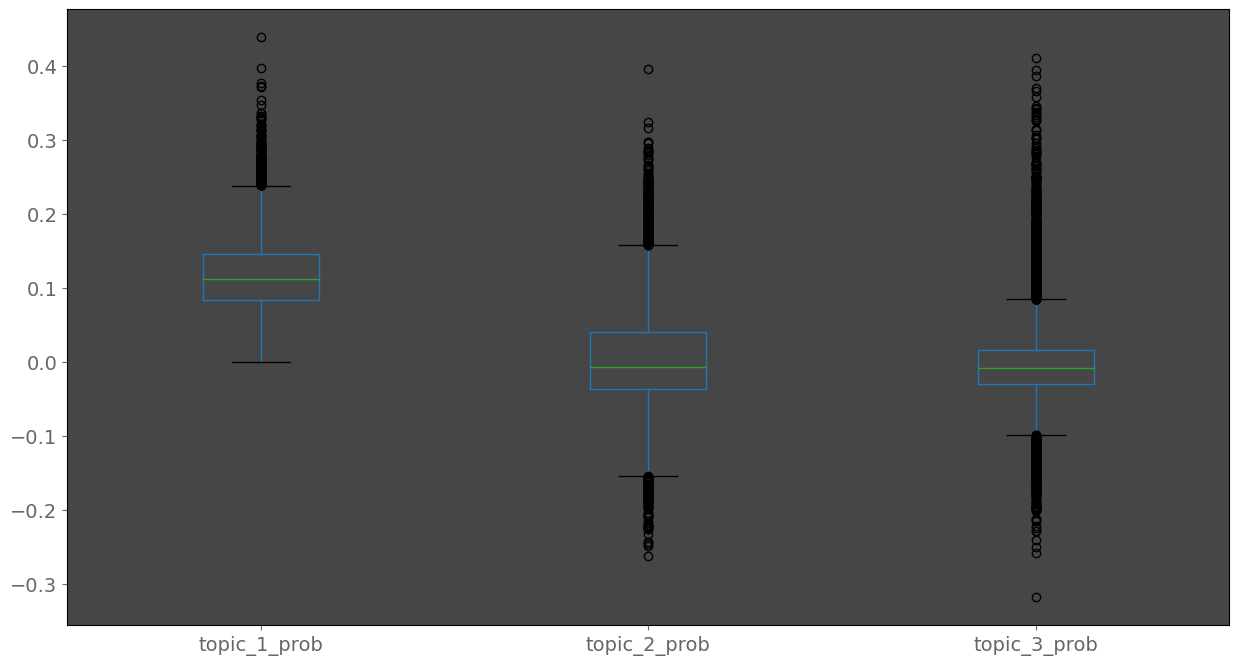

In [43]:
# plot boxplot of top 3 topic scores to check their distribution
cols = ['topic_1_prob','topic_2_prob','topic_3_prob']
colors = [sns.xkcd_rgb['greenish cyan'], sns.xkcd_rgb['cyan'], sns.xkcd_rgb['reddish pink']]
fig = plt.figure(figsize=[15,8])
news_topics.boxplot(column=cols,
                   grid=False)
plt.show()

### Latent Dirichlet Allocation (LDA) 

In [44]:
# lda instance
lda_model = LatentDirichletAllocation(n_components=3,
                                     random_state=12,
                                     learning_method='online',
                                     max_iter=5,
                                     learning_offset=50)
# fit model
lda_model.fit(X)

LatentDirichletAllocation(learning_method='online', learning_offset=50,
                          max_iter=5, n_components=3, random_state=12)

In [45]:
lda_model.components_.shape

(3, 73392)

In [46]:
doc_topic_lda = lda_model.transform(X)
doc_topic_lda.shape

(11314, 3)

In [47]:
word2topics_lda = map_word2topic(lda_model.components_, terms)

# print topic results
print('Topics\t\tWords')
for idx, item in zip(word2topics_lda.index, word2topics_lda):
    print(idx,'\t',item)

Topics		Words
topic 0 	 ['edu', 'would', 'one', 'writes', 'com', 'article', 'know', 'like', 'get', 'people']
topic 1 	 ['max', 'bilinsky', 'giz', 'bhj', 'bxn', 'woof', 'thud', 'xelm', 'networld', 'mailreader']
topic 2 	 ['het', 'rolex', 'niet', 'tesrt', 'chz', 'een', 'van', 'meer', 'horloges', 'dit']


/var/folders/rx/0lw0w5ds7t36p51ggtr6fdr80000gn/T/ipykernel_49727/3300574441.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  word2topics = pd.Series()
